# Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


# 1.0 Functions & Dataset
## 1.1 Call for library & function

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers6 import PlotROCCurve

## 1.2 Import & Inspect Dataset

In [2]:
output_path = 'C:\\Users\\joeta\\python_smu_mitb\\isss623_aha\\groupProject'
path = output_path

df_train = pd.read_csv((os.path.join(path, 'train_drop_v3.csv')))
df_test = pd.read_csv((os.path.join(path, 'test_drop_v3.csv')))

confidence_interval = 95
random_seed = 0

In [3]:
print(len(df_train))
print(len(df_test))
len(df_train) + len(df_test)

273032
68258


341290

In [4]:
df_train['outcome_critical'].value_counts(dropna = False).sort_index()

0    261423
1     11609
Name: outcome_critical, dtype: int64

# 2. Variable Selection 

In [5]:
pd.set_option('display.max_rows', None)
list(df_train)

['intime_ed',
 'outtime_ed',
 'gender',
 'age',
 'outcome_hospitalization',
 'outcome_inhospital_mortality',
 'ed_death',
 'outcome_icu_transfer_12h',
 'outcome_critical',
 'n_ed_30d',
 'n_ed_90d',
 'n_ed_365d',
 'outcome_ed_revisit_3d',
 'n_hosp_30d',
 'n_hosp_90d',
 'n_hosp_365d',
 'n_icu_30d',
 'n_icu_90d',
 'n_icu_365d',
 'ed_los_hours',
 'triage_temperature',
 'triage_heartrate',
 'triage_resprate',
 'triage_o2sat',
 'triage_sbp',
 'triage_dbp',
 'triage_pain',
 'triage_acuity',
 'chiefcom_chest_pain',
 'chiefcom_abdominal_pain',
 'chiefcom_headache',
 'chiefcom_shortness_of_breath',
 'chiefcom_back_pain',
 'chiefcom_cough',
 'chiefcom_nausea_vomiting',
 'chiefcom_fever_chills',
 'chiefcom_syncope',
 'chiefcom_dizziness',
 'cci_MI',
 'cci_CHF',
 'cci_PVD',
 'cci_Stroke',
 'cci_Dementia',
 'cci_Pulmonary',
 'cci_Rheumatic',
 'cci_PUD',
 'cci_Liver1',
 'cci_DM1',
 'cci_DM2',
 'cci_Paralysis',
 'cci_Renal',
 'cci_Cancer1',
 'cci_Liver2',
 'cci_Cancer2',
 'cci_HIV',
 'eci_CHF',
 'eci_

## 2.1 Trim Dataset
### 2.1.1 Full Features
> based on train_drop_v3 & test_drop_v3

In [6]:
variable = list(df_train.columns)
feature_to_remove = {'intime_ed','outtime_ed','outcome_hospitalization','outcome_inhospital_mortality','ed_death', 
                   'outcome_icu_transfer_12h','outcome_critical','outcome_ed_revisit_3d'}
variable = [item for item in variable if item not in feature_to_remove]

outcome = "outcome_critical"

### 2.1.2 Features for First Prediction
> based on ED triage. Hence, assumming without information about the number of unique medication given during ED, length of stay in ED as well as insurance information.

In [7]:
variable2 = ['gender','age',
             'n_ed_30d','n_ed_90d','n_ed_365d','n_hosp_30d','n_hosp_90d','n_hosp_365d','n_icu_30d','n_icu_90d',
             'n_icu_365d',
             'triage_temperature','triage_heartrate','triage_resprate','triage_o2sat','triage_sbp','triage_dbp',
             'triage_pain','triage_acuity',
             'chiefcom_chest_pain','chiefcom_abdominal_pain','chiefcom_headache','chiefcom_shortness_of_breath',
             'chiefcom_back_pain','chiefcom_cough','chiefcom_nausea_vomiting','chiefcom_fever_chills','chiefcom_syncope',
             'chiefcom_dizziness',
             'cci_MI','cci_CHF','cci_PVD','cci_Stroke','cci_Dementia','cci_Pulmonary','cci_Rheumatic','cci_PUD',
             'cci_Liver1','cci_DM1','cci_DM2','cci_Paralysis','cci_Renal','cci_Cancer1','cci_Liver2','cci_Cancer2',
             'cci_HIV',    
             'eci_CHF','eci_Arrhythmia','eci_Valvular','eci_PHTN','eci_PVD','eci_HTN1','eci_HTN2','eci_Paralysis',
             'eci_NeuroOther','eci_Pulmonary','eci_DM1','eci_DM2','eci_Hypothyroid','eci_Renal','eci_Liver','eci_PUD',
             'eci_HIV','eci_Lymphoma','eci_Tumor2','eci_Tumor1','eci_Rheumatic','eci_Coagulopathy','eci_Obesity', 
             'eci_WeightLoss','eci_FluidsLytes','eci_BloodLoss','eci_Anemia','eci_Alcohol','eci_Drugs','eci_Psychoses',
             'eci_Depression',
             'n_medrecon','triage_MAP','score_CCI','score_CART','score_REMS','score_NEWS2','score_MEWS']

### 2.1.3 Features for Second Prediction Prior to Discharge
> included information that are not included in the first prediction 

In [8]:
variable3 = ['gender','age','ed_los_hours','n_med','n_medrecon',
             'n_ed_30d','n_ed_90d','n_ed_365d','n_hosp_30d','n_hosp_90d','n_hosp_365d','n_icu_30d','n_icu_90d',
             'n_icu_365d',
             'triage_temperature','triage_heartrate','triage_resprate','triage_o2sat','triage_sbp','triage_dbp','triage_pain',
             'triage_acuity',
             'ed_temperature_last','ed_heartrate_last','ed_resprate_last','ed_o2sat_last','ed_sbp_last',
             'ed_dbp_last','ed_pain_last',
             'chiefcom_chest_pain','chiefcom_abdominal_pain','chiefcom_headache','chiefcom_shortness_of_breath',
             'chiefcom_back_pain','chiefcom_cough','chiefcom_nausea_vomiting','chiefcom_fever_chills','chiefcom_syncope',
             'chiefcom_dizziness',
             'cci_MI','cci_CHF','cci_PVD','cci_Stroke','cci_Dementia','cci_Pulmonary','cci_Rheumatic','cci_PUD',
             'cci_Liver1','cci_DM1','cci_DM2','cci_Paralysis','cci_Renal','cci_Cancer1','cci_Liver2','cci_Cancer2',
             'cci_HIV',    
             'eci_CHF','eci_Arrhythmia','eci_Valvular','eci_PHTN','eci_PVD','eci_HTN1','eci_HTN2','eci_Paralysis',
             'eci_NeuroOther','eci_Pulmonary','eci_DM1','eci_DM2','eci_Hypothyroid','eci_Renal','eci_Liver','eci_PUD',
             'eci_HIV','eci_Lymphoma','eci_Tumor2','eci_Tumor1','eci_Rheumatic','eci_Coagulopathy','eci_Obesity', 
             'eci_WeightLoss','eci_FluidsLytes','eci_BloodLoss','eci_Anemia','eci_Alcohol','eci_Drugs','eci_Psychoses',
             'eci_Depression',
             'triage_MAP','score_CCI','score_CART','score_REMS','score_NEWS2','score_MEWS']

### 2.1.4 Revised 2nd Prediction Features (BEST Model)
> trimmed away less deadly or critical eci_feature

In [9]:
variable4 = ['gender','age','ed_los_hours','n_med','n_medrecon',
             'n_ed_30d','n_ed_90d','n_ed_365d','n_hosp_30d','n_hosp_90d','n_hosp_365d','n_icu_30d','n_icu_90d',
             'n_icu_365d',
             'triage_temperature','triage_heartrate','triage_resprate','triage_o2sat','triage_sbp','triage_dbp','triage_pain',
             'triage_acuity',
             'ed_temperature_last','ed_heartrate_last','ed_resprate_last','ed_o2sat_last','ed_sbp_last',
             'ed_dbp_last','ed_pain_last',
             'chiefcom_chest_pain','chiefcom_abdominal_pain','chiefcom_headache','chiefcom_shortness_of_breath',
             'chiefcom_back_pain','chiefcom_cough','chiefcom_nausea_vomiting','chiefcom_fever_chills','chiefcom_syncope',
             'chiefcom_dizziness',
             'cci_MI','cci_CHF','cci_PVD','cci_Stroke','cci_Dementia','cci_Pulmonary','cci_Rheumatic','cci_PUD','cci_Liver1',
             'cci_DM1','cci_DM2','cci_Paralysis','cci_Renal','cci_Cancer1','cci_Liver2','cci_Cancer2','cci_HIV', 
             'eci_CHF','eci_Arrhythmia','eci_Valvular','eci_PHTN','eci_HTN2','eci_Paralysis','eci_DM1','eci_DM2',
             'eci_Renal','eci_Liver','eci_PUD','eci_HIV','eci_Lymphoma','eci_Tumor2','eci_Rheumatic','eci_Coagulopathy',
             'eci_FluidsLytes','eci_BloodLoss','eci_Anemia',
             'triage_MAP','score_CCI','score_CART','score_REMS','score_NEWS2','score_MEWS']

## 2.2 Set Up Machine Learning Pipeline 
### 2.2.1 Full Features

In [10]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [11]:
X_train.dtypes.to_frame().T

,gender,age,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,...,age_group_Middle-Aged Adults,age_group_Older Adults,age_group_Elderly,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,...,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64


In [12]:
total_count = y_train.count()
print("Total number of values in y_train:", total_count)

Total number of values in y_train: 273032


### 2.2.2 First Prediction

In [13]:
X_train2 = df_train[variable2].copy()
X_test2 = df_test[variable2].copy()

### 2.2.3 Second Prediction

In [14]:
X_train3 = df_train[variable3].copy()
X_test3 = df_test[variable3].copy()

### 2.2.4 Revised Second Prediction (BEST Model)

In [15]:
X_train4 = df_train[variable4].copy()
X_test4 = df_test[variable4].copy()

## 2.3 Class Ratio

In [16]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = -0.04078470775468046 : 1


# 3.  Modeling script

In [17]:
# Containers for all results
result_list = []

## 3.1 Logistic Regression Model
### 3.1.1 Full Features

Logistic Regression:


C:\Users\joeta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.628811836242676 seconds
AUC: 0.8727945814424323
AUPRC: 0.3233058153451993
Sensitivity: 0.8027787190782786
Specificity: 0.7820294914787083
Score thresold: 0.03700890664388839
2.5 97.5


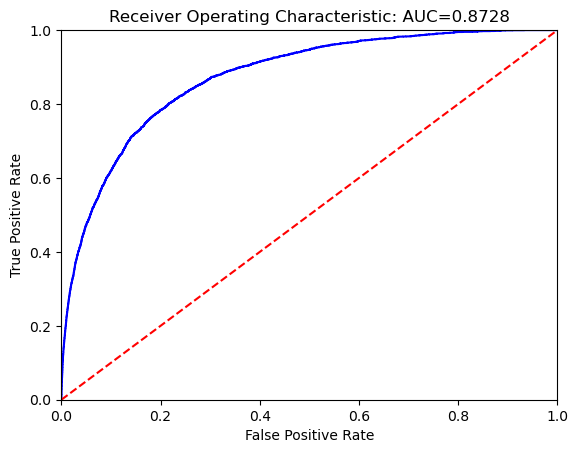

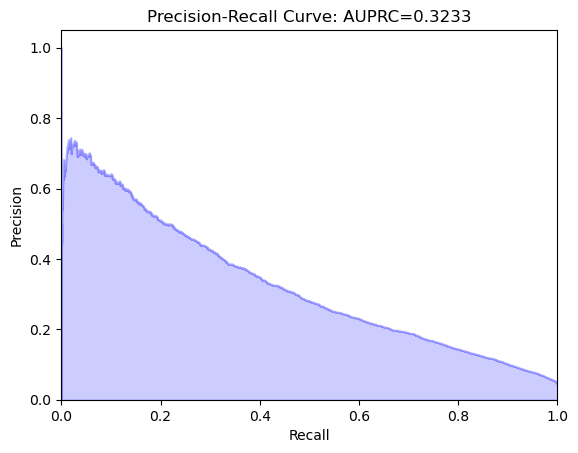

In [18]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression

# create logistic regression model. For reproducibility, set 'random_seed' which is 0
logreg = LogisticRegression(random_state = random_seed)

# record the current time before training the model to cacluate the total training time.
start = time.time()

# logistic regression model to use the training data.
logreg.fit(X_train, y_train)

# calculate the total time it took to train this model.
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

# use the trained model to predict the probabilities for the test data ('X_test')
probs = logreg.predict_proba(X_test)

# generate a ROC curve for the model and computes performance metrics like AUC (area under the curve).
result = PlotROCCurve(probs[:,1], y_test, ci = confidence_interval, random_seed = random_seed)
results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.1.2 LR - First Prediction

Logistic Regression:


C:\Users\joeta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 6.3691582679748535 seconds
AUC: 0.8325526943081752
AUPRC: 0.21717415562466585
Sensitivity: 0.7583869874618774
Specificity: 0.7515580259390264
Score thresold: 0.042339115131815104
2.5 97.5


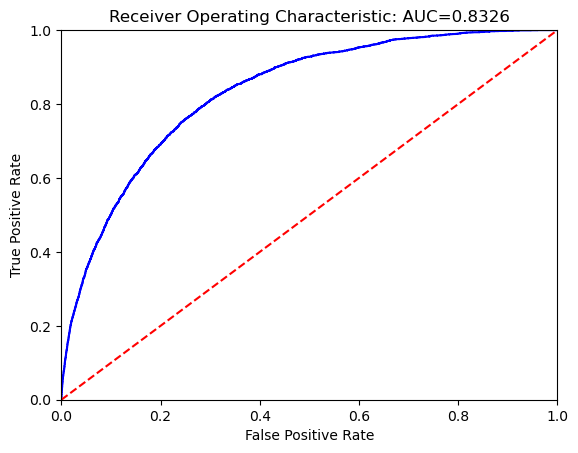

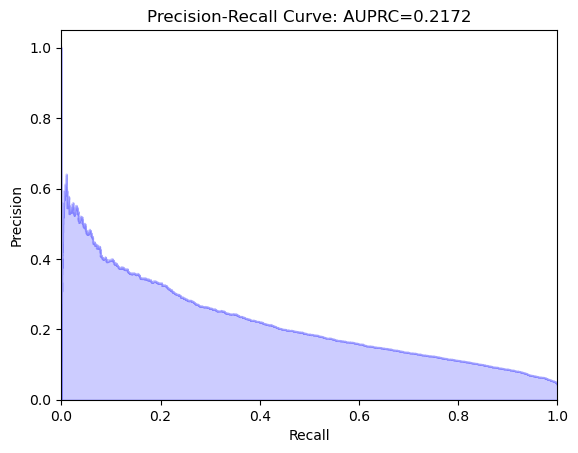

In [19]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression

# create logistic regression model. For reproducibility, set 'random_seed' which is 0
logreg = LogisticRegression(random_state = random_seed)

# record the current time before training the model to cacluate the total training time.
start = time.time()

# logistic regression model to use the training data.
logreg.fit(X_train2, y_train)

# calculate the total time it took to train this model.
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

# use the trained model to predict the probabilities for the test data ('X_test')
probs = logreg.predict_proba(X_test2)

# generate a ROC curve for the model and computes performance metrics like AUC (area under the curve).
result = PlotROCCurve(probs[:,1], y_test, ci = confidence_interval, random_seed = random_seed)
results = ["LRv2"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.1.3 LR - Second Prediction

Logistic Regression:


C:\Users\joeta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 6.283723592758179 seconds
AUC: 0.8662148403507565
AUPRC: 0.32259828788906886
Sensitivity: 0.7685530328702135
Specificity: 0.7983677094339044
Score thresold: 0.040904892003417306
2.5 97.5


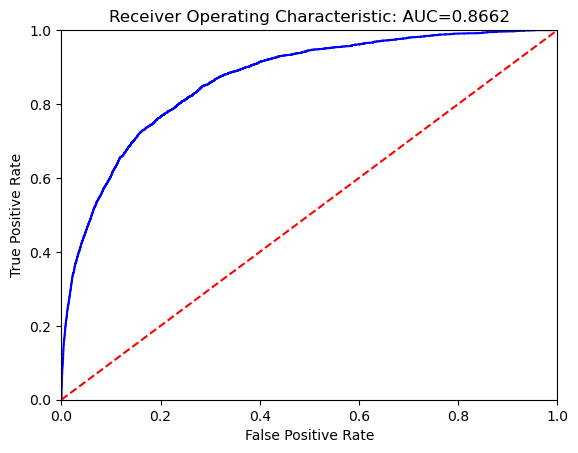

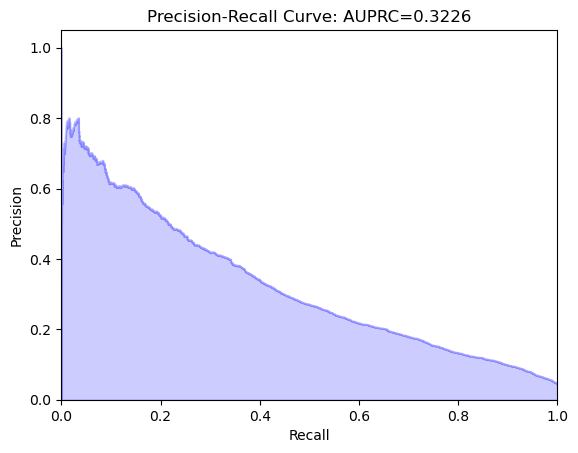

In [20]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression

# create logistic regression model. For reproducibility, set 'random_seed' which is 0
logreg = LogisticRegression(random_state = random_seed)

# record the current time before training the model to cacluate the total training time.
start = time.time()

# logistic regression model to use the training data.
logreg.fit(X_train3, y_train)

# calculate the total time it took to train this model.
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

# use the trained model to predict the probabilities for the test data ('X_test')
probs = logreg.predict_proba(X_test3)

# generate a ROC curve for the model and computes performance metrics like AUC (area under the curve).
result = PlotROCCurve(probs[:,1], y_test, ci = confidence_interval, random_seed = random_seed)
results = ["LRv3"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.1.4 LR - Revised Second Prediction (BEST Model)

Logistic Regression:


C:\Users\joeta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 6.108332872390747 seconds
AUC: 0.863127210394664
AUPRC: 0.3171712655138199
Sensitivity: 0.7760081328363266
Specificity: 0.7866691166337452
Score thresold: 0.03947446660371479
2.5 97.5


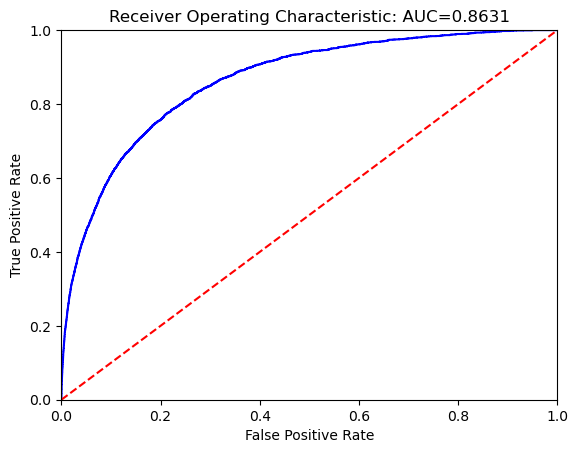

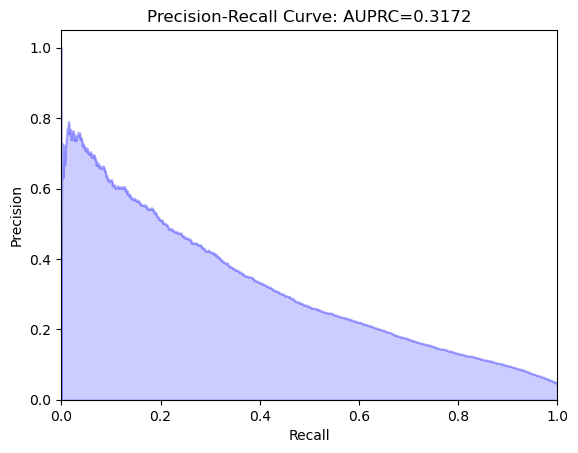

In [21]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression

# create logistic regression model. For reproducibility, set 'random_seed' which is 0
logreg = LogisticRegression(random_state = random_seed)

# record the current time before training the model to cacluate the total training time.
start = time.time()

# logistic regression model to use the training data.
logreg.fit(X_train4, y_train)

# calculate the total time it took to train this model.
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

# use the trained model to predict the probabilities for the test data ('X_test')
probs = logreg.predict_proba(X_test4)

# generate a ROC curve for the model and computes performance metrics like AUC (area under the curve).
result = PlotROCCurve(probs[:,1], y_test, ci = confidence_interval, random_seed = random_seed)
results = ["LRv4"]
results.extend(result)
results.append(runtime)
result_list.append(results)

## 3.2 Random Forest Model
### 3.2.1 Full Features

RandomForest:
Training time: 76.82735562324524 seconds
AUC: 0.9169882157652423
AUPRC: 0.42055234554892773
Sensitivity: 0.8603863097255168
Specificity: 0.8128378274916931
Score thresold: 0.07
2.5 97.5


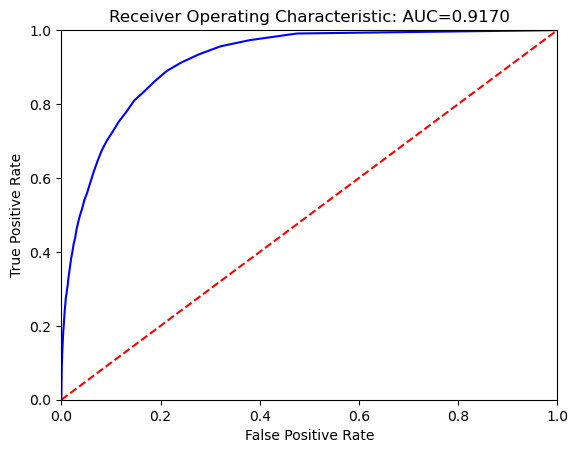

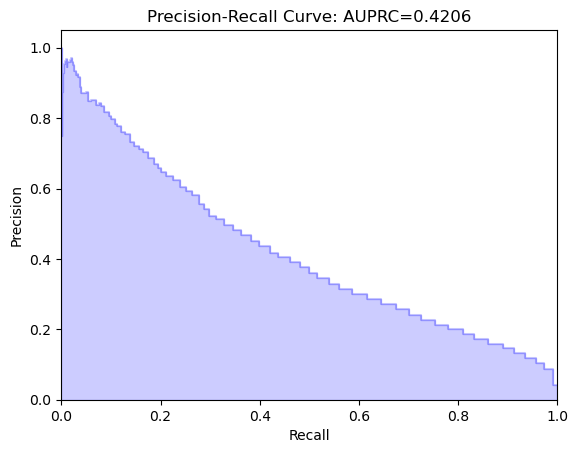

[0.00688121 0.03101672 0.00344974 0.00550127 0.0096116  0.00362517
 0.00579452 0.00919272 0.00192809 0.00367054 0.00629904 0.07198086
 0.03057451 0.03243425 0.01958361 0.02194114 0.0392122  0.03254398
 0.01497491 0.02590573 0.00318037 0.00318949 0.00314676 0.00069476
 0.00127332 0.00134374 0.00157922 0.00209305 0.00156685 0.00172879
 0.00240963 0.00261056 0.00221552 0.00233031 0.00133883 0.00291165
 0.00112536 0.00143557 0.00209601 0.00303493 0.00204521 0.00102227
 0.00222352 0.00230996 0.00167444 0.00155609 0.00052121 0.00252446
 0.00346057 0.00236999 0.00230151 0.00203852 0.00235665 0.00441055
 0.00112053 0.00248299 0.00283868 0.00230461 0.00284069 0.00255105
 0.00222835 0.00210139 0.00106456 0.00051487 0.00100532 0.00157481
 0.00215073 0.00140009 0.00283247 0.00250984 0.00226603 0.00344471
 0.00131988 0.00220154 0.00221894 0.00172317 0.00106686 0.00314054
 0.03580867 0.06085845 0.05606945 0.02208219 0.04549049 0.03818656
 0.01332732 0.03108566 0.02714034 0.00258864 0.00891223 0.0085

In [22]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(random_state = random_seed)
start = time.time()
rf.fit(X_train, 
       y_train)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)

importancesRF1 = rf.feature_importances_
print(importancesRF1)
results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.2.2 RF - First Prediction

RandomForest:
Training time: 79.50536179542542 seconds
AUC: 0.8385070259899134
AUPRC: 0.2446750949767371
Sensitivity: 0.7610979329041003
Specificity: 0.7588926148804875
Score thresold: 0.06
2.5 97.5


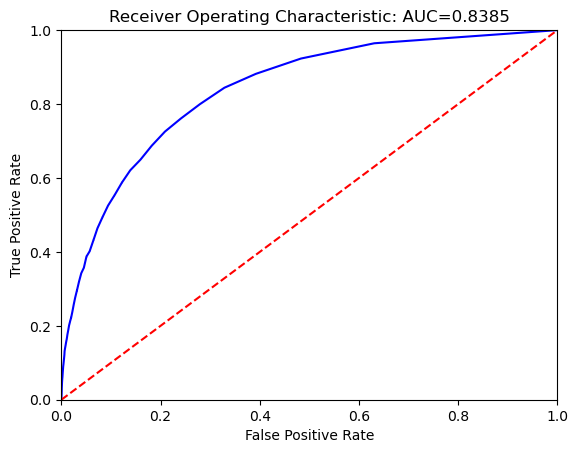

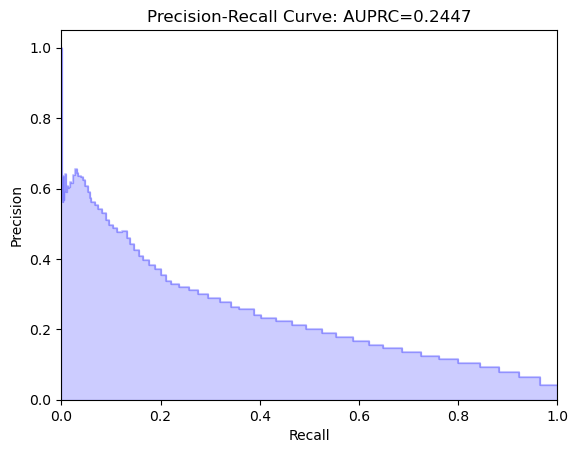

[0.0122973  0.05975676 0.0055898  0.00867201 0.01530649 0.00568343
 0.00896169 0.01433192 0.00196939 0.00460699 0.00804102 0.06245528
 0.06468446 0.03645479 0.04384135 0.07233366 0.06327962 0.0285535
 0.03688532 0.00503075 0.00631638 0.0041539  0.0012407  0.00225414
 0.00228415 0.00282146 0.00424248 0.00290708 0.00290402 0.00375232
 0.00361404 0.00325623 0.00371088 0.00201167 0.00473361 0.00170269
 0.00206093 0.00327243 0.00468064 0.0031332  0.00136817 0.0032509
 0.00350726 0.00236222 0.00207281 0.00079407 0.00334195 0.00578256
 0.00380182 0.0036343  0.00317487 0.00351335 0.0069351  0.001582
 0.00421748 0.00460322 0.00350491 0.00450633 0.00431021 0.00318687
 0.00326436 0.00167184 0.00073999 0.00140701 0.00207522 0.0031247
 0.00213005 0.0046141  0.00446284 0.00385456 0.00544841 0.00201946
 0.00365206 0.00382378 0.00273391 0.0017753  0.00534656 0.05057089
 0.072443   0.02913663 0.02361746 0.02841765 0.02956782 0.02086357]


In [23]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(random_state = random_seed)
start = time.time()
rf.fit(X_train2, 
       y_train)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = rf.predict_proba(X_test2)
result = PlotROCCurve(probs[:,1],y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)

importancesRF2 = rf.feature_importances_
print(importancesRF2)
results = ["RFv2"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.2.3 RF - Second Prediction

RandomForest:
Training time: 79.54459023475647 seconds
AUC: 0.9126806562090702
AUPRC: 0.41874626928636466
Sensitivity: 0.8451372416130125
Specificity: 0.8157165388090097
Score thresold: 0.07
2.5 97.5


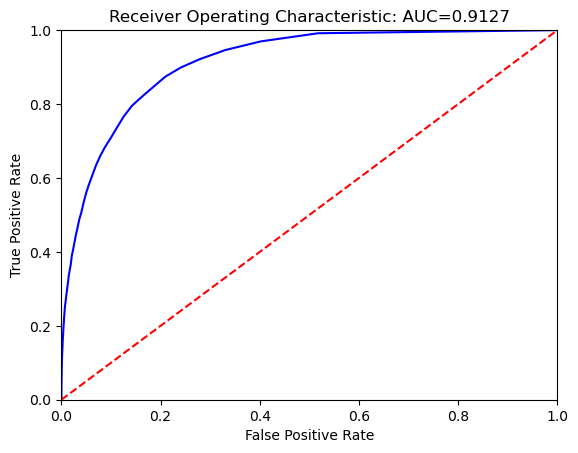

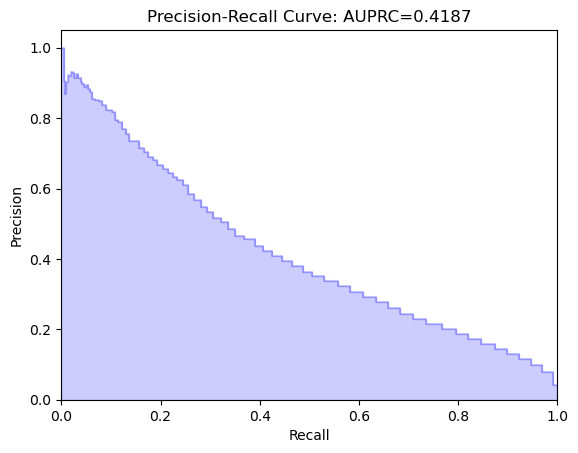

[0.00735217 0.03401999 0.07562806 0.03268736 0.02871062 0.00349116
 0.00583237 0.01003281 0.00377053 0.0060467  0.00959432 0.00189029
 0.00359727 0.00638635 0.03264419 0.03447566 0.02166003 0.02503753
 0.04198124 0.03466925 0.01589637 0.026424   0.03760567 0.06181647
 0.05905002 0.02301282 0.0476286  0.03926484 0.01398854 0.00327212
 0.00330904 0.00325275 0.00078303 0.00122997 0.00124213 0.00153242
 0.0022965  0.00155153 0.00176425 0.00241417 0.00251657 0.00212861
 0.00243389 0.00130099 0.0030165  0.00117747 0.00148112 0.00229091
 0.00313292 0.00221054 0.00095996 0.00233943 0.00247616 0.0016903
 0.00157698 0.00055444 0.00263594 0.00360563 0.0024414  0.00241082
 0.00223706 0.0024626  0.00457932 0.00111357 0.00272949 0.00299376
 0.00236953 0.00296193 0.00266099 0.00239761 0.00222698 0.00114382
 0.00050718 0.0010075  0.00162324 0.0022095  0.00141299 0.00315647
 0.00275446 0.00226659 0.00351716 0.00133032 0.00230332 0.00235555
 0.00174232 0.00103625 0.00336927 0.03944513 0.02026278 0.01735

In [24]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(random_state = random_seed)
start = time.time()
rf.fit(X_train3, 
       y_train)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = rf.predict_proba(X_test3)
result = PlotROCCurve(probs[:,1],y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)

importancesRF3 = rf.feature_importances_
print(importancesRF3)
results = ["RFv3"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.2.4 RF - Revised Second Prediction (BEST model) 

RandomForest:
Training time: 79.125741481781 seconds
AUC: 0.9158641916665036
AUPRC: 0.4172066385735953
Sensitivity: 0.8590308370044053
Specificity: 0.8192383664844504
Score thresold: 0.07
2.5 97.5


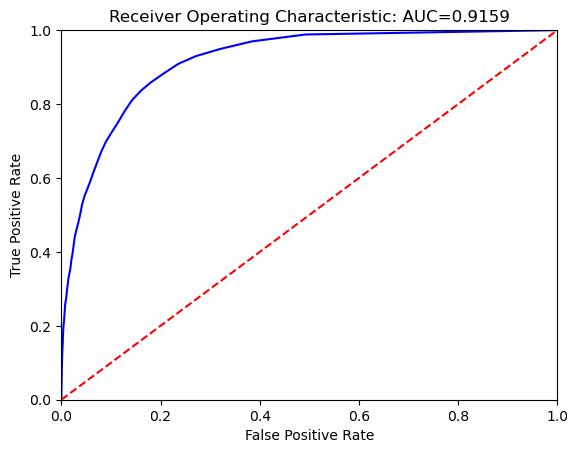

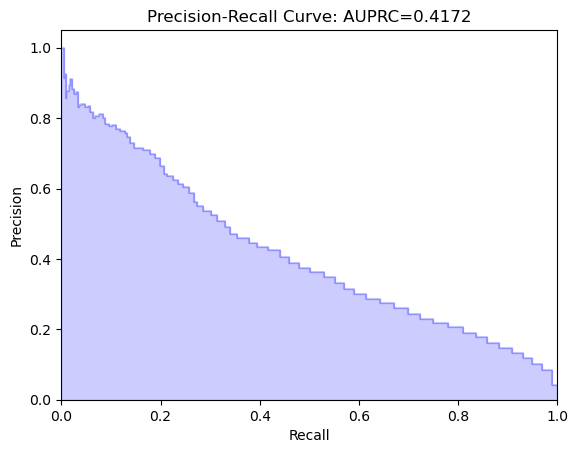

[0.00729069 0.03455224 0.08129061 0.03381352 0.02917385 0.00363274
 0.00614443 0.01020567 0.00385925 0.00626118 0.01001063 0.00185838
 0.00359563 0.00648002 0.03380484 0.03556655 0.02175485 0.02516924
 0.04233295 0.03489979 0.01571591 0.0280274  0.03884898 0.06473544
 0.0596582  0.02325483 0.04905403 0.04011027 0.01421794 0.00340827
 0.00334594 0.00325662 0.00074648 0.00128555 0.00136002 0.00160633
 0.00233799 0.00165756 0.00174155 0.00254347 0.00266664 0.00274243
 0.00263683 0.00145212 0.00360072 0.00120128 0.00147509 0.00243158
 0.00322807 0.0022496  0.00104954 0.00260864 0.00270702 0.00173755
 0.00179311 0.00052964 0.00259138 0.00380702 0.00270774 0.00244054
 0.00475429 0.00117222 0.00257118 0.00310755 0.0025055  0.00247642
 0.00114824 0.00055004 0.00102744 0.00172985 0.00144566 0.00313646
 0.00370245 0.00138456 0.00237772 0.04110097 0.0214363  0.01794197
 0.01933582 0.02015257 0.0126764 ]


In [25]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(random_state = random_seed)
start = time.time()
rf.fit(X_train4, 
       y_train)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = rf.predict_proba(X_test4)
result = PlotROCCurve(probs[:,1],y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)

importancesRF4 = rf.feature_importances_
print(importancesRF4)
results = ["RFv4"]
results.extend(result)
results.append(runtime)
result_list.append(results)

## 3.3 Gradient Boosting Model
### 3.3.1  Full Features

GradientBoosting:
Training time: 150.45403575897217 seconds
AUC: 0.9261142445447694
AUPRC: 0.43049068106546406
Sensitivity: 0.8634361233480177
Specificity: 0.8291607331526483
Score thresold: 0.05428477369882013
2.5 97.5


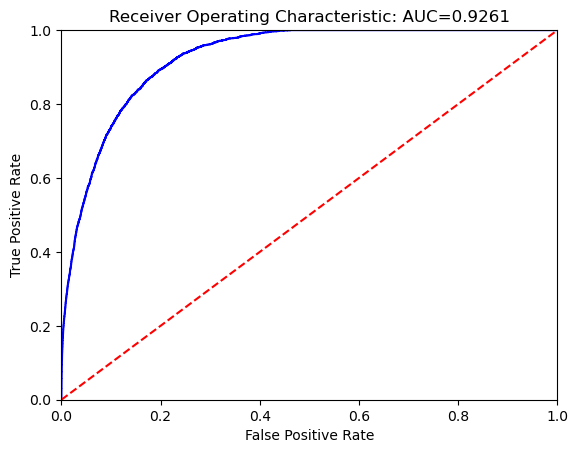

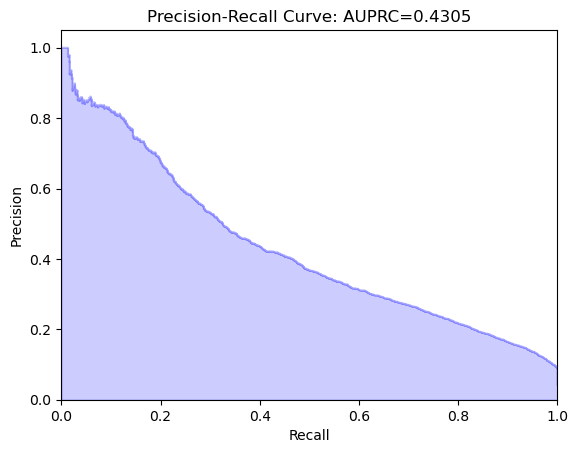

[8.61676779e-04 8.09960921e-03 0.00000000e+00 6.87987935e-05
 3.81747070e-03 0.00000000e+00 0.00000000e+00 2.33605838e-04
 4.87436793e-04 3.92835272e-03 9.10168886e-03 2.96043103e-01
 8.28890124e-05 3.74185444e-03 4.34282776e-04 3.33407691e-03
 1.83242379e-02 5.16644357e-04 3.65988720e-03 1.13004733e-01
 3.36807864e-03 0.00000000e+00 1.92562026e-03 0.00000000e+00
 0.00000000e+00 2.76118957e-04 0.00000000e+00 1.07334164e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.46426489e-04 4.22139891e-05 0.00000000e+00 1.66368536e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.61084204e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.61184339e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.88572364e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.37940641e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [26]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state = random_seed)
start = time.time()
gb.fit(X_train, 
       y_train)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], 
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
importancesGB1 = gb.feature_importances_
print(importancesGB1)
results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.3.2 GB - First Prediction

GradientBoosting:
Training time: 108.5618622303009 seconds
AUC: 0.8540758465619284
AUPRC: 0.2597397384114944
Sensitivity: 0.7732971873941037
Specificity: 0.7747255271257293
Score thresold: 0.046754458668402464
2.5 97.5


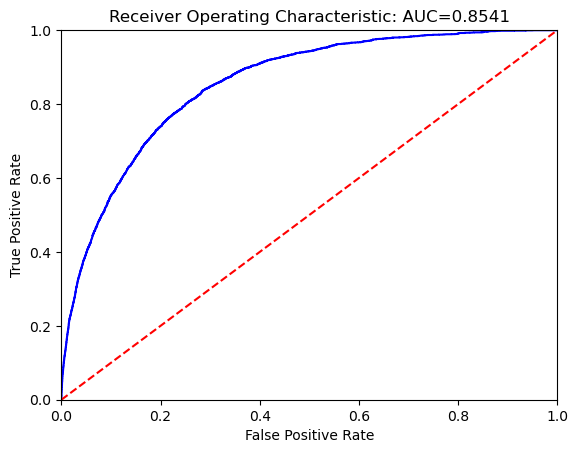

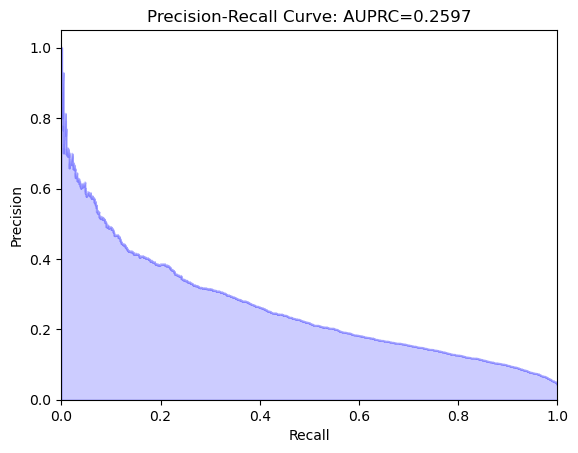

[2.77676864e-03 1.92524956e-02 3.41775356e-04 7.03816564e-04
 1.76149579e-02 0.00000000e+00 2.09458060e-04 1.71880713e-04
 1.75934396e-03 1.08928768e-02 3.88017100e-02 4.98519383e-03
 1.68592740e-02 1.86929233e-02 6.79903955e-02 2.90347876e-02
 2.81686404e-03 6.65891919e-03 3.69956182e-01 1.34567483e-02
 2.60383523e-04 4.78523996e-04 4.24200782e-04 0.00000000e+00
 4.38542520e-04 0.00000000e+00 0.00000000e+00 2.11373664e-03
 1.59688556e-03 0.00000000e+00 9.06838735e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.32552024e-04
 0.00000000e+00 2.06494465e-04 3.00329763e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.64892067e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.49028994e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.77817057e-04
 1.43711972e-03 2.41719146e-05 1.58314408e-04 0.00000000e+00
 3.97558215e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.29085427e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [27]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state = random_seed)
start = time.time()
gb.fit(X_train2, 
       y_train)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = gb.predict_proba(X_test2)
result = PlotROCCurve(probs[:,1], 
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)

importancesGB2 = gb.feature_importances_
print(importancesGB2)
results = ["GBv2"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.3.3 GB - Second Prediction

GradientBoosting:
Training time: 135.93176817893982 seconds
AUC: 0.9234516046949683
AUPRC: 0.4271058698515118
Sensitivity: 0.8529312097594036
Specificity: 0.8312738297579126
Score thresold: 0.054838272227951346
2.5 97.5


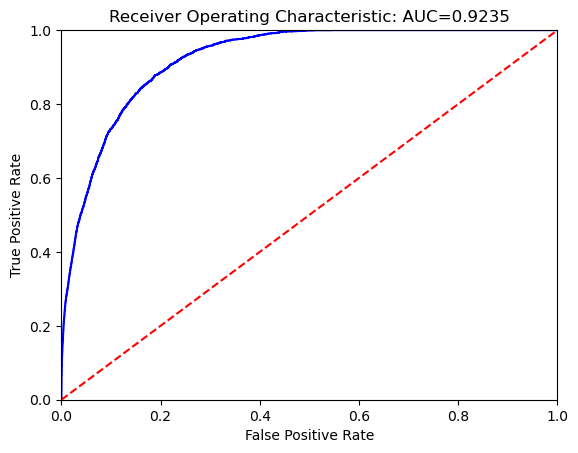

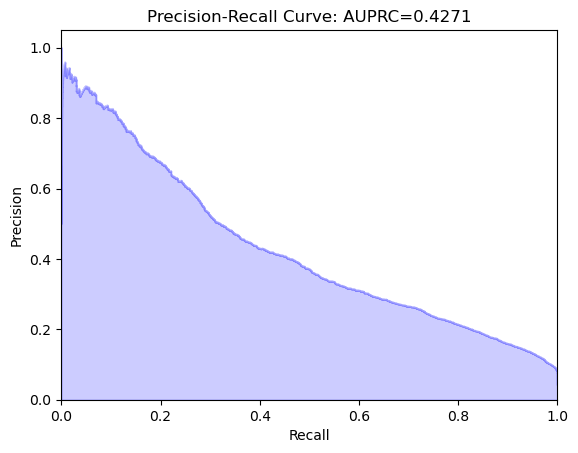

[8.61644316e-04 6.00647796e-03 3.00047434e-01 4.49814759e-02
 3.02982995e-03 1.28460977e-04 0.00000000e+00 4.12336315e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.57682233e-04
 3.95111153e-03 9.31161500e-03 5.72382752e-05 4.04437277e-03
 3.99005221e-04 8.52007252e-03 1.78577929e-02 5.95273846e-04
 4.39655157e-03 1.19310966e-01 1.11899576e-02 8.64495045e-02
 2.21569866e-01 1.85735674e-03 5.51139796e-02 1.37425378e-02
 0.00000000e+00 3.67335927e-03 0.00000000e+00 1.81552831e-03
 1.98192843e-04 0.00000000e+00 3.46344150e-04 0.00000000e+00
 1.18409280e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.43827424e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.91016363e-04 0.00000000e+00 0.00000000e+00
 5.16768392e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.70031651e-04 0.00000000e+00
 0.00000000e+00 0.000000

In [28]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state = random_seed)
start = time.time()
gb.fit(X_train3, 
       y_train)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = gb.predict_proba(X_test3)
result = PlotROCCurve(probs[:,1], 
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
importancesGB3 = gb.feature_importances_
print(importancesGB3)
results = ["GBv3"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.3.4 GB - Revised Second Prediction (BEST Model) 

GradientBoosting:
Training time: 140.91214990615845 seconds
AUC: 0.9234070688015523
AUPRC: 0.4292919659021286
Sensitivity: 0.8542866824805151
Specificity: 0.8306766502825118
Score thresold: 0.054599392542151834
2.5 97.5


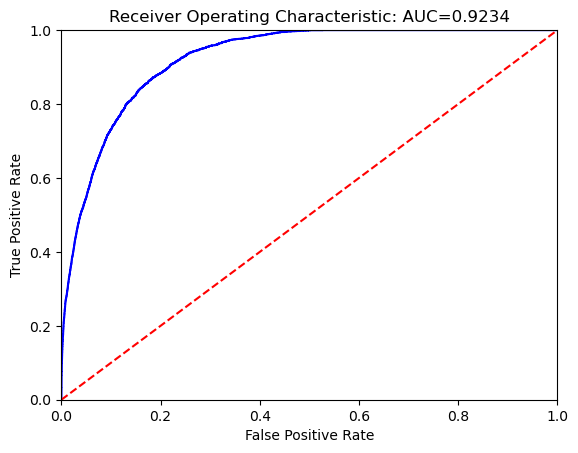

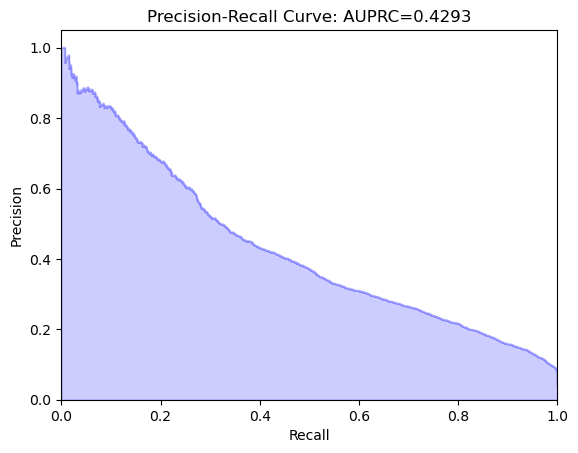

[8.71534693e-04 6.22565930e-03 2.98844175e-01 4.51993324e-02
 3.56609060e-03 1.27669112e-04 0.00000000e+00 4.49902410e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.46480681e-04
 4.12415894e-03 9.46544351e-03 1.12068291e-04 4.43117603e-03
 5.22764804e-04 8.29615193e-03 1.73856289e-02 6.22781606e-04
 3.90348633e-03 1.19725662e-01 1.12882809e-02 8.66939306e-02
 2.21773584e-01 1.81084467e-03 5.47576818e-02 1.41120115e-02
 0.00000000e+00 3.80489566e-03 0.00000000e+00 1.61851635e-03
 1.98243297e-04 0.00000000e+00 1.53512223e-04 0.00000000e+00
 9.07054161e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.00737351e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.03090624e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.87885743e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [29]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state = random_seed)
start = time.time()
gb.fit(X_train4, 
       y_train)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = gb.predict_proba(X_test4)
result = PlotROCCurve(probs[:,1], 
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
importancesGB4 = gb.feature_importances_
print(importancesGB4)
results = ["GBv4"]
results.extend(result)
results.append(runtime)
result_list.append(results)

## 3.4 Keras Model - Multi-Layer Perceptron (MLP)
### 3.4.1 Full Features

In [30]:
# Defines a custom class MLP that inherits from tf.keras.Model,which means it's a Keras model.
# This class will represent our Multi-Layer Perceptron (MLP) model.

class MLP(tf.keras.Model):
# define the layers of our MLP model.
    def __init__(self):
        super(MLP, self).__init__()      
# The Dense layers represent fully connected layers in the neural network. 
# The first layer has 128 neurons with a ReLU activation function, 
# the second layer has 64 neurons with a ReLU activation function, 
# and the final output layer has one neuron with a sigmoid activation function 
# for binary classification.
        self.dense_1 = Dense(128, activation = 'relu')
        self.dense_2 = Dense(64, activation = 'relu')
        self.classifier = Dense(1, activation = 'sigmoid')

        
# The call method is used to define the forward pass of the model. 
# It specifies how the input data x will pass through the layers defined in the __init__ method. 
# In this case, the input data first goes through dense_1, then dense_2, and finally 
# through the classifier layer. The output of the classifier layer is the model's prediction.
    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [31]:
# skip this cell if not retraining
# an instance of the MLP class is created, which represents our MLP model.
mlp = MLP()

# compile it with various settings. 
# The loss function used for training is binary cross-entropy since it's a binary 
# classification problem.
# The optimizer used is Adam with a learning rate of 0.001. 
# The metrics parameter includes several evaluation metrics such as accuracy, 
# area under the ROC curve (AUC), 
# area under the precision-recall curve (AUPRC), 
# true positives, true negatives, precision, and recall.
mlp.compile(loss = 'binary_crossentropy', 
            optimizer = optimizers.Adam(learning_rate = 0.001), 
            metrics = ['accuracy', 'AUC', {'auprc': metrics.AUC(name = 'auprc', curve = 'PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
# the model is trained using the fit method on the training data (X_train and y_train). 
# The batch_size determines the number of samples used in each gradient update during 
# training. The epochs parameter specifies the number of times the entire training dataset 
# is passed through the model during training. 
mlp.fit(X_train.astype(np.float32), 
        y_train, 
        batch_size = 200, 
        epochs = 20)

# The training time (runtime) is recorded.
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

# After training, the model is saved to a file named 'critical_triage_mlp' for future use.
mlp.save('critical_triage_mlp')

Epoch 1/20
1366/1366 [==============================] - 5s 2ms/step - loss: 0.1466 - accuracy: 0.9578 - auc: 0.8312 - auprc: 0.2842 - true_positives: 1828.0000 - true_negatives: 259670.0000 - precision: 0.5105 - recall: 0.1575
Epoch 2/20
1366/1366 [==============================] - 2s 2ms/step - loss: 0.1250 - accuracy: 0.9595 - auc: 0.8857 - auprc: 0.3532 - true_positives: 2091.0000 - true_negatives: 259875.0000 - precision: 0.5746 - recall: 0.1801
Epoch 3/20
1366/1366 [==============================] - 2s 2ms/step - loss: 0.1187 - accuracy: 0.9603 - auc: 0.9033 - auprc: 0.3810 - true_positives: 2173.0000 - true_negatives: 260024.0000 - precision: 0.6083 - recall: 0.1872
Epoch 4/20
1366/1366 [==============================] - 2s 2ms/step - loss: 0.1156 - accuracy: 0.9606 - auc: 0.9111 - auprc: 0.3908 - true_positives: 2215.0000 - true_negatives: 260063.0000 - precision: 0.6196 - recall: 0.1908
Epoch 5/20
1366/1366 [==============================] - 3s 2ms/step - loss: 0.1131 - accurac

MLP:
Training time: 244.51980113983154 seconds
AUC: 0.9265228923702366
AUPRC: 0.43955430825324726
Sensitivity: 0.862419518807184
Specificity: 0.8261135865986801
Score thresold: 0.039966296
2.5 97.5


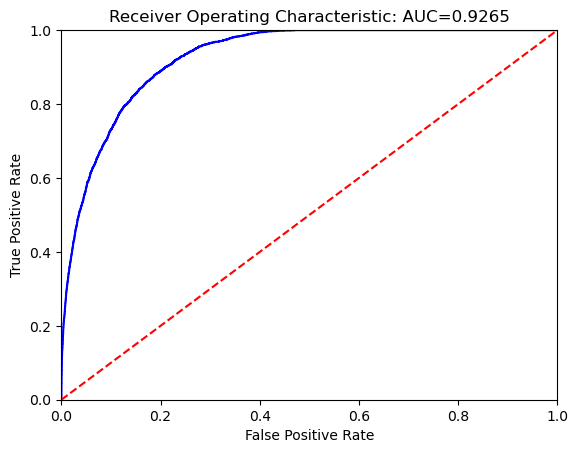

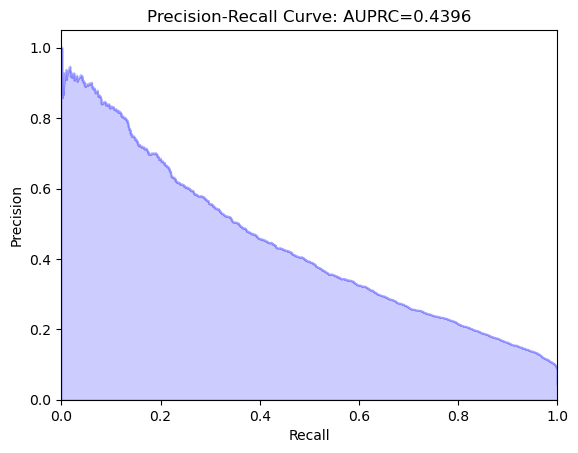

In [32]:
print("MLP:")
print('Training time:', runtime, 'seconds')
# This line loads the previously saved Keras model named 'critical_triage_mlp' from a file 
# and assigns it to the variable mlp. 
mlp = load_model('critical_triage_mlp')

# This line uses the loaded model (mlp) to make predictions on the test data X_test. 
# The predictions are probabilities generated by the sigmoid activation function in the 
# output layer.
probs = mlp.predict(X_test.astype(np.float32))

# This line calls the function PlotROCCurve to generate a Receiver Operating Characteristic (ROC) 
# curve for the model's predictions (probs) and the ground truth labels (y_test). 
# The ci, confidence_interval, and random_seed are arguments passed to the function.
result = PlotROCCurve(probs,
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.4.2 MLP - First Prediction

In [33]:
mlp = MLP()

mlp.compile(loss = 'binary_crossentropy', 
            optimizer = optimizers.Adam(learning_rate = 0.001), 
            metrics = ['accuracy', 'AUC', {'auprc': metrics.AUC(name = 'auprc', curve = 'PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train2.astype(np.float32), 
        y_train, 
        batch_size = 200, 
        epochs = 20)

runtime = time.time() - start
print('Training time:', runtime, 'seconds')

mlp.save('critical_triage_mlp')

Epoch 1/20
1366/1366 [==============================] - 5s 2ms/step - loss: 0.1810 - accuracy: 0.9553 - auc: 0.7662 - auprc: 0.1602 - true_positives: 648.0000 - true_negatives: 260177.0000 - precision: 0.3421 - recall: 0.0558
Epoch 2/20
1366/1366 [==============================] - 4s 3ms/step - loss: 0.1454 - accuracy: 0.9573 - auc: 0.8171 - auprc: 0.2153 - true_positives: 692.0000 - true_negatives: 260692.0000 - precision: 0.4863 - recall: 0.0596
Epoch 3/20
1366/1366 [==============================] - 4s 3ms/step - loss: 0.1419 - accuracy: 0.9574 - auc: 0.8316 - auprc: 0.2280 - true_positives: 648.0000 - true_negatives: 260763.0000 - precision: 0.4954 - recall: 0.0558
Epoch 4/20
1366/1366 [==============================] - 4s 3ms/step - loss: 0.1402 - accuracy: 0.9576 - auc: 0.8388 - auprc: 0.2332 - true_positives: 595.0000 - true_negatives: 260870.0000 - precision: 0.5183 - recall: 0.0513
Epoch 5/20
1366/1366 [==============================] - 4s 3ms/step - loss: 0.1402 - accuracy: 0

MLP:
Training time: 279.4386007785797 seconds
AUC: 0.8558948703227953
AUPRC: 0.2638243137037606
Sensitivity: 0.8054896645205015
Specificity: 0.7544673618448252
Score thresold: 0.05092529
2.5 97.5


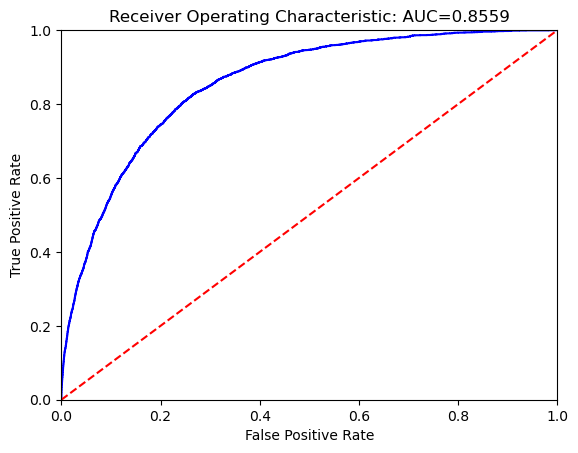

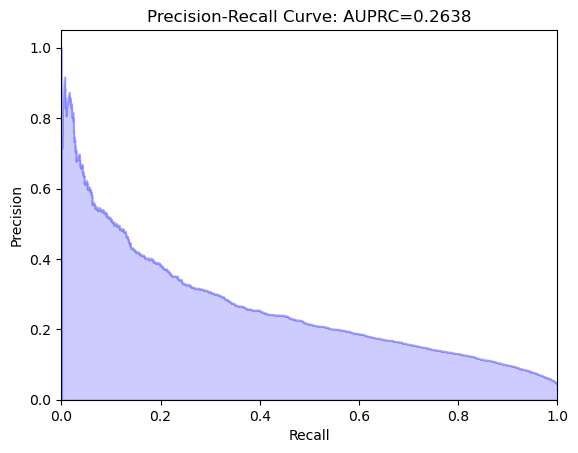

AttributeError: 'MLP' object has no attribute 'feature_importances_'

In [34]:
print("MLP:")
print('Training time:', runtime, 'seconds')
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test2.astype(np.float32))
result = PlotROCCurve(probs,
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
importancesMLP2 = mlp.feature_importances_
print(importancesMLP2)
results = ["MLPv2"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [ ]:
from sklearn.metrics import accuracy_score

mlp.fit(X_train2.astype(np.float32), y_train)
baseline_preds = mlp.predict(X_test2.astype(np.float32))

baseline_acc = accuracy_score(y_test, baseline_preds)
feature_importances = {}

for feature in X_test2.columns:
    permuted_values = X_test2.copy()
    np.random.shuffle(permuted_values[feature].values)
    # Get predictions with shuffled feature values
    shuffled_preds = mlp.predict(permuted_values.astype(np.float32))
    # Calculate accuracy with shuffled feature values
    shuffled_acc = accuracy_score(y_test, shuffled_preds)
    # Calculate permutation importance
    feature_importance = baseline_acc - shuffled_acc
    # Store the importance score
    feature_importances[feature] = feature_importance

# Print the feature importances
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance}")

### 3.4.3 MLP - Second Prediction

In [35]:
mlp = MLP()
mlp.compile(loss = 'binary_crossentropy', 
            optimizer = optimizers.Adam(learning_rate = 0.001), 
            metrics = ['accuracy', 'AUC', {'auprc': metrics.AUC(name = 'auprc', curve = 'PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train3.astype(np.float32), 
        y_train, 
        batch_size = 200, 
        epochs = 20)

runtime = time.time() - start
print('Training time:', runtime, 'seconds')

mlp.save('critical_triage_mlp')

Epoch 1/20
1366/1366 [==============================] - 4s 2ms/step - loss: 0.2185 - accuracy: 0.9553 - auc: 0.8035 - auprc: 0.2173 - true_positives: 1578.0000 - true_negatives: 259254.0000 - precision: 0.4211 - recall: 0.1359
Epoch 2/20
1366/1366 [==============================] - 3s 2ms/step - loss: 0.1323 - accuracy: 0.9590 - auc: 0.8607 - auprc: 0.3220 - true_positives: 1876.0000 - true_negatives: 259971.0000 - precision: 0.5637 - recall: 0.1616
Epoch 3/20
1366/1366 [==============================] - 4s 3ms/step - loss: 0.1220 - accuracy: 0.9597 - auc: 0.8953 - auprc: 0.3573 - true_positives: 1918.0000 - true_negatives: 260106.0000 - precision: 0.5929 - recall: 0.1652
Epoch 4/20
1366/1366 [==============================] - 4s 3ms/step - loss: 0.1172 - accuracy: 0.9602 - auc: 0.9075 - auprc: 0.3772 - true_positives: 1965.0000 - true_negatives: 260187.0000 - precision: 0.6139 - recall: 0.1693
Epoch 5/20
1366/1366 [==============================] - 4s 3ms/step - loss: 0.1141 - accurac

MLP:
Training time: 235.09105587005615 seconds
AUC: 0.923263586741114
AUPRC: 0.4335945219967965
Sensitivity: 0.8583531006438495
Specificity: 0.8247048555285038
Score thresold: 0.055624045
2.5 97.5


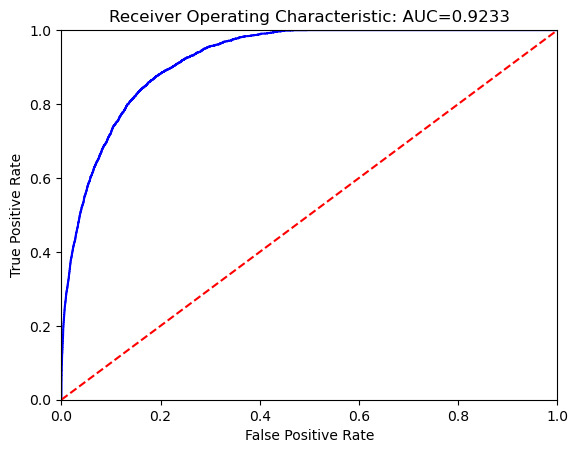

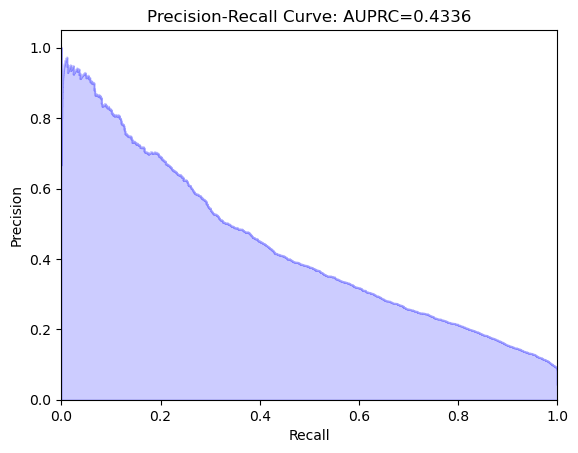

In [36]:
print("MLP:")
print('Training time:', runtime, 'seconds')
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test3.astype(np.float32))
result = PlotROCCurve(probs,
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
results = ["MLPv3"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.4.4 MLP - Revised Second Prediction (BEST Model)

In [37]:
mlp = MLP()

mlp.compile(loss = 'binary_crossentropy', 
            optimizer = optimizers.Adam(learning_rate = 0.001), 
            metrics = ['accuracy', 'AUC', {'auprc': metrics.AUC(name = 'auprc', curve = 'PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train4.astype(np.float32), 
        y_train, 
        batch_size = 200, 
        epochs = 20)

runtime = time.time() - start
print('Training time:', runtime, 'seconds')

mlp.save('critical_triage_mlp')

Epoch 1/20
1366/1366 [==============================] - 9s 4ms/step - loss: 0.1794 - accuracy: 0.9568 - auc: 0.8102 - auprc: 0.2413 - true_positives: 1817.0000 - true_negatives: 259410.0000 - precision: 0.4744 - recall: 0.1565
Epoch 2/20
1366/1366 [==============================] - 5s 4ms/step - loss: 0.1284 - accuracy: 0.9591 - auc: 0.8778 - auprc: 0.3323 - true_positives: 2026.0000 - true_negatives: 259837.0000 - precision: 0.5609 - recall: 0.1745
Epoch 3/20
1366/1366 [==============================] - 5s 4ms/step - loss: 0.1202 - accuracy: 0.9598 - auc: 0.9004 - auprc: 0.3616 - true_positives: 1992.0000 - true_negatives: 260053.0000 - precision: 0.5925 - recall: 0.1716
Epoch 4/20
1366/1366 [==============================] - 5s 4ms/step - loss: 0.1162 - accuracy: 0.9602 - auc: 0.9091 - auprc: 0.3821 - true_positives: 2016.0000 - true_negatives: 260162.0000 - precision: 0.6152 - recall: 0.1737
Epoch 5/20
1366/1366 [==============================] - 5s 3ms/step - loss: 0.1145 - accurac

MLP:
Training time: 290.46026587486267 seconds
AUC: 0.924257767669761
AUPRC: 0.43244484926445137
Sensitivity: 0.870213486953575
Specificity: 0.8159921601053486
Score thresold: 0.035661798
2.5 97.5


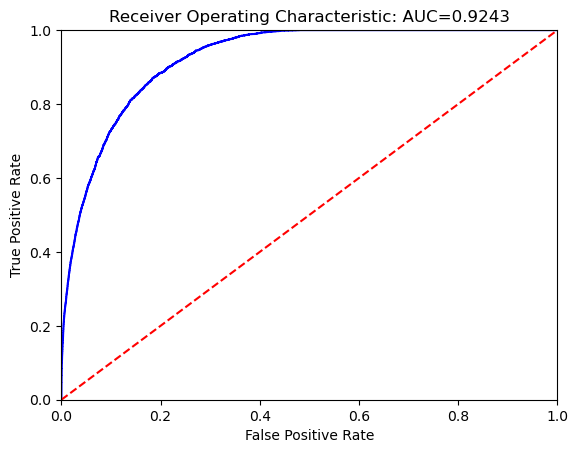

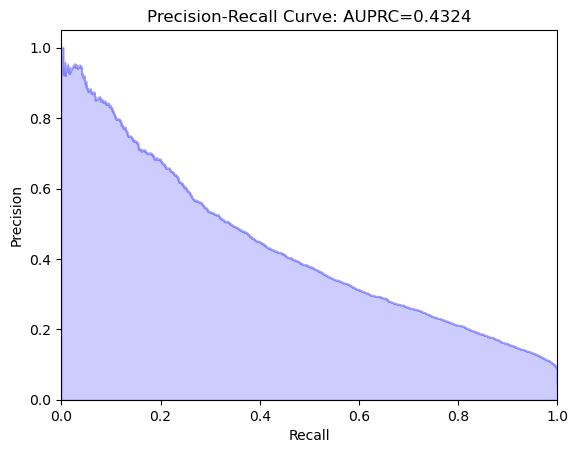

AttributeError: 'MLP' object has no attribute 'feature_importances_'

In [38]:
print("MLP:")
print('Training time:', runtime, 'seconds')
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test4.astype(np.float32))
result = PlotROCCurve(probs,
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
importancesMLP4 = mlp.feature_importances_
print(importancesMLP4)
results = ["MLPv4"]
results.extend(result)
results.append(runtime)
result_list.append(results)

## 3.5 Scores
### 3.5.1 set up function

In [39]:
def get_score_performance(s, random_seed = 0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,
                          y_test, 
                          ci = confidence_interval, 
                          random_seed = random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)

### 3.5.2 score_NEWS 

score_NEWS
AUC: 0.6920542689085962
AUPRC: 0.13329337422116927
Sensitivity: 0.5099966113181972
Specificity: 0.7943099514600273
Score thresold: 2
2.5 97.5


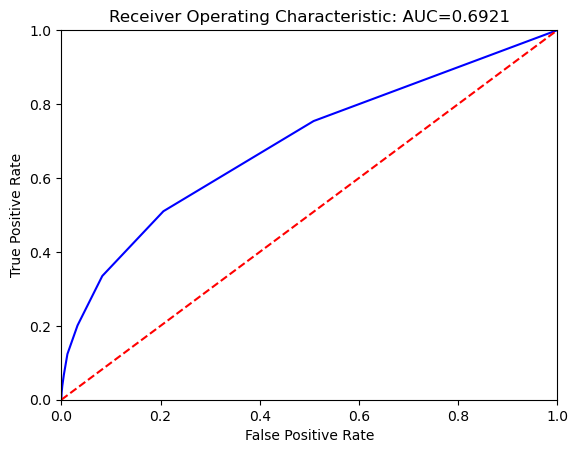

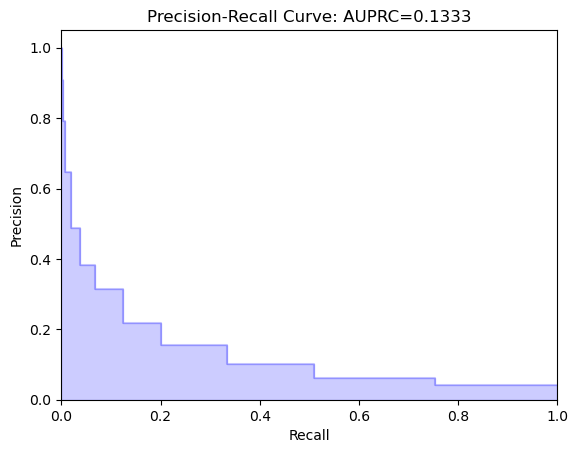

In [40]:
get_score_performance("score_NEWS", random_seed=random_seed)

### 3.5.2 score_NEWS2

score_NEWS2
AUC: 0.6677514760369314
AUPRC: 0.11640742196015022
Sensitivity: 0.6963741104710268
Specificity: 0.5251504432909182
Score thresold: 1
2.5 97.5


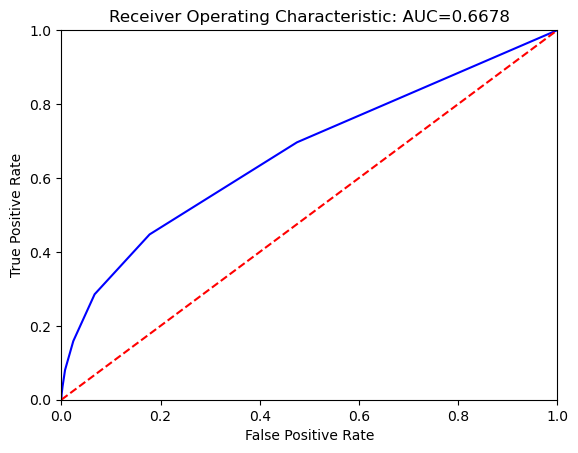

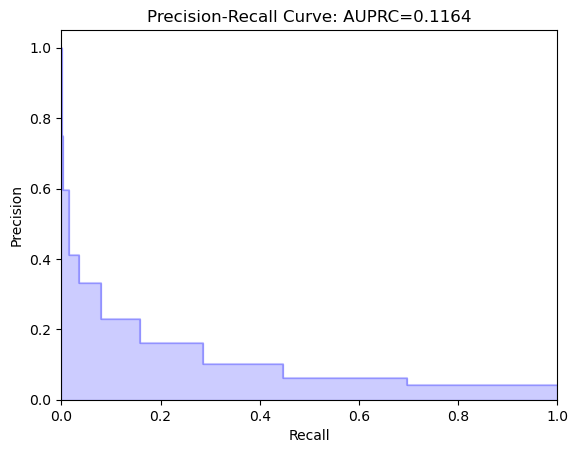

In [41]:
get_score_performance("score_NEWS2", random_seed=random_seed)

### 3.5.3 score_REMS 

score_REMS
AUC: 0.6915061837307086
AUPRC: 0.07986325987953911
Sensitivity: 0.6818027787190782
Specificity: 0.6101489886229654
Score thresold: 5
2.5 97.5


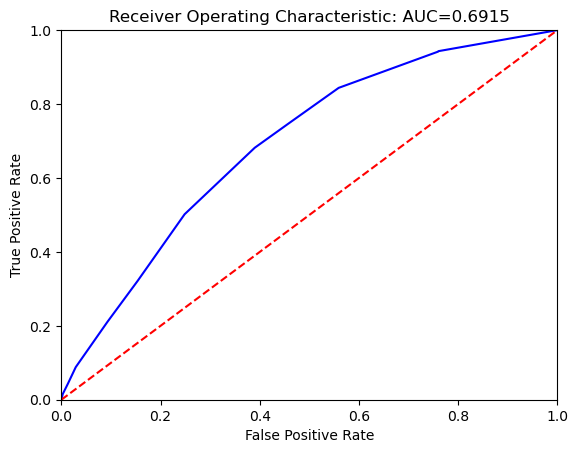

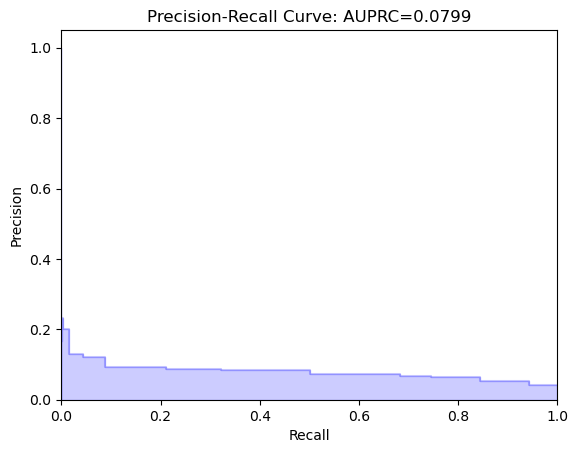

In [42]:
get_score_performance("score_REMS", random_seed=random_seed)

### 3.5.4 score_MEWS

score_MEWS
AUC: 0.6422182720896308
AUPRC: 0.0884017829673158
Sensitivity: 0.494747543205693
Specificity: 0.7693815364356041
Score thresold: 2
2.5 97.5


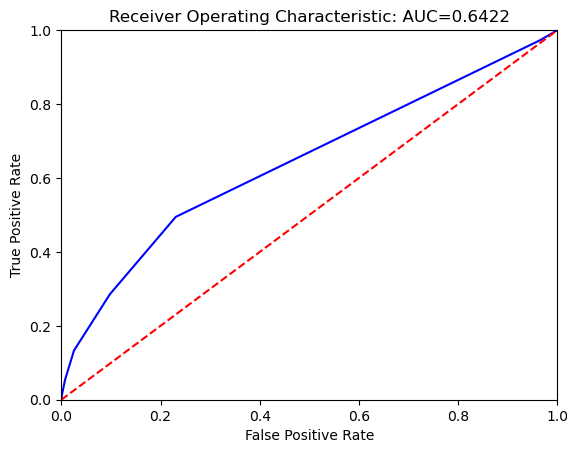

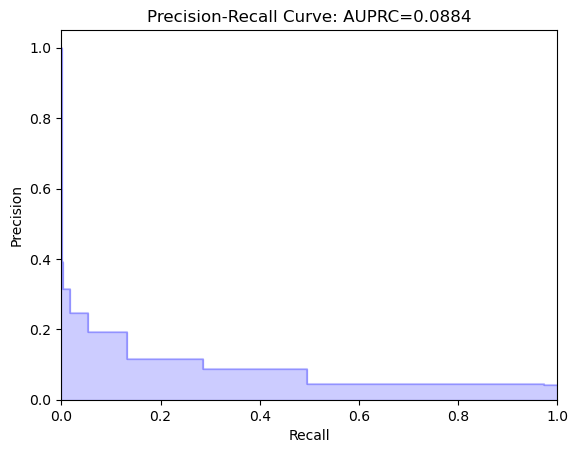

In [43]:
get_score_performance("score_MEWS", random_seed=random_seed)

# 4. Performance output
## 4.1 Consolidate Results

In [44]:
result_df = pd.DataFrame(result_list, columns = ['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                                 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                                 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 
                                                 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])

result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index = False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()

formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]

formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'

formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'

formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'

formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'

formatted_result_df[['Runtime']] = result_df[['runtime']]

formatted_result_df.to_csv(os.path.join(path, 'task2v7.csv'), index = False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.037,0.873 (0.868-0.878),0.323 (0.306-0.344),0.803 (0.776-0.81),0.782 (0.779-0.817),5.629
1,LRv2,0.042,0.833 (0.826-0.84),0.217 (0.205-0.23),0.758 (0.751-0.788),0.752 (0.723-0.754),6.369
2,LRv3,0.041,0.866 (0.86-0.871),0.323 (0.301-0.345),0.769 (0.763-0.807),0.798 (0.758-0.808),6.284
3,LRv4,0.039,0.863 (0.856-0.869),0.317 (0.298-0.338),0.776 (0.762-0.794),0.787 (0.773-0.792),6.108
4,RF,0.070,0.917 (0.913-0.921),0.421 (0.408-0.439),0.86 (0.841-0.871),0.813 (0.81-0.826),76.827
5,RFv2,0.060,0.839 (0.832-0.845),0.245 (0.234-0.26),0.761 (0.741-0.773),0.759 (0.756-0.777),79.505
6,RFv3,0.070,0.913 (0.909-0.916),0.419 (0.406-0.44),0.845 (0.82-0.863),0.816 (0.801-0.84),79.545
7,RFv4,0.070,0.916 (0.911-0.919),0.417 (0.402-0.436),0.859 (0.831-0.871),0.819 (0.818-0.842),79.126
8,GB,0.054,0.926 (0.923-0.931),0.43 (0.417-0.454),0.863 (0.856-0.88),0.829 (0.818-0.842),150.454
9,GBv2,0.047,0.854 (0.848-0.861),0.26 (0.249-0.273),0.773 (0.766-0.805),0.775 (0.748-0.784),108.562


## 4.2 Compute Importance
### 4.2.1 First Prediction

In [45]:
importance_df1 = pd.DataFrame(zip(variable2, importancesMLP2), columns = ['Variable','Importance'])

importance_df1.to_csv(os.path.join(path, 'importances_critical_triagev1.csv'))

importance_df1.sort_values(by = 'Importance', 
                            axis = 0,
                            ascending = False)

NameError: name 'importancesMLP2' is not defined

### 4.2.2 Second Prediction (BEST Model) 

In [46]:
importance_df2 = pd.DataFrame(zip(variable4, importancesMLP4), columns = ['Variable','Importance'])

importance_df2.to_csv(os.path.join(path, 'importances_critical_triagev2.csv'))

importance_df2.sort_values(by = 'Importance', 
                            axis = 0,
                            ascending = False)

NameError: name 'importancesMLP4' is not defined

## 4.3 Visualise Importance

In [47]:
importance_df_sorted = importance_df.sort_values(by = 'Importance', 
                                                 ascending = True)
plt.figure(figsize=(8, 16))
plt.barh(importance_df_sorted['Variable'], importance_df_sorted['Importance'])
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

NameError: name 'importance_df' is not defined